In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils

from ClusteringAdvClassifier import ClusterAdversarialClassifier as Classifier

# Testing Cluster Adversarial Classifier

## Load Data

In [2]:
# MNIST
X_train, y_train, X_test, y_test = utils.load_mnist()
channels, size, classes = 1, 28, 10
dimensions = (size, size)

# Fashion MNIST
#X_train, y_train, X_test, y_test = utils.load_fashion_mnist()
#channels, size, classes = 1, 28, 10
#dimensions = (size, size)

# CIFAR-10
#X_train, y_train, X_test, y_test = utils.load_cifar10()
#channels, size, classes = 3, 32, 10
#dimensions = (size, size, channels)

## Create Black Box Attack (training data for baseline model)

### Train model for black box attack

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 - Training loss: 0.2693243377530741
Epoch 1 - Training loss: 0.11178697283907946
Epoch 2 - Training loss: 0.1002232917487482
Epoch 3 - Training loss: 0.1054664682677192
Epoch 4 - Training loss: 0.03941948946681816

Training Time (in minutes) = 2.554802437623342
Predicted Class = 5
Number Of Images Tested = 10000

Model Accuracy = 0.9906


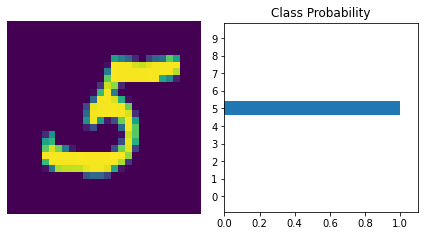

In [3]:
from model import My_VGG as Model

attacked_model = Model(in_channels=channels, in_size=size, num_classes=classes)
attacked_model = utils.train_model(attacked_model, X_train, X_test, y_train, y_test, epochs=5)

### Create training and test data for baseline (adversarially trained) model

In [4]:
baseline_training_eps = 2e-2

train_dataloader = utils.create_dataloader(X_train, y_train)
test_dataloader = utils.create_dataloader(X_test, y_test)
adv_train_data = utils.add_adversarial_noise(attacked_model, train_dataloader, eps=baseline_training_eps)
adv_test_data = utils.add_adversarial_noise(attacked_model, test_dataloader, eps=baseline_training_eps)

baseline_train_data = np.concatenate((X_train, adv_train_data), axis=0)
baseline_train_labels = np.concatenate((y_train, y_train), axis=0)

test_data = np.concatenate((X_test, adv_test_data), axis=0)
test_labels = np.concatenate((y_test, y_test), axis=0)

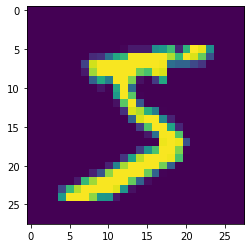

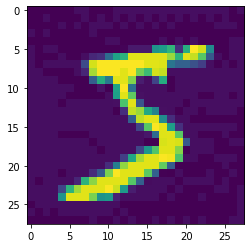

In [5]:
plt.imshow(X_train[0].reshape(dimensions))
plt.show()

plt.imshow(adv_train_data[0].reshape(dimensions))
plt.show()

## Train Baseline Model (adversarial training)

In [6]:
baseline_model = Model(in_channels=channels, in_size=size, num_classes=classes)

Epoch 0 - Training loss: 0.17848245758177944
Epoch 1 - Training loss: 0.0965152207682076
Epoch 2 - Training loss: 0.051541712788645555
Epoch 3 - Training loss: 0.03482149326417207
Epoch 4 - Training loss: 0.026030291776424505

Training Time (in minutes) = 5.124779093265533
Predicted Class = 1
Number Of Images Tested = 20000

Model Accuracy = 0.9924


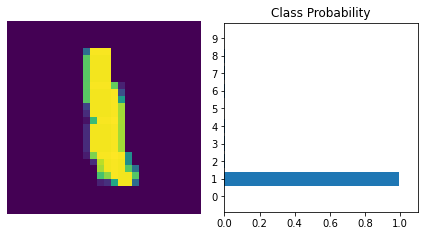

In [7]:
baseline_model = utils.train_model(baseline_model, baseline_train_data, test_data, baseline_train_labels, test_labels, epochs=5)

## Train Clustering Classifier

### Train Base Neural Network For Clustering Detector/Classifier

In [8]:
model = Model(in_channels=channels, in_size=size, num_classes=classes)

Epoch 0 - Training loss: 0.23322200667282353
Epoch 1 - Training loss: 0.11248995469159787
Epoch 2 - Training loss: 0.11149498268434926
Epoch 3 - Training loss: 0.06727379549303274
Epoch 4 - Training loss: 0.04492101508417476

Training Time (in minutes) = 2.5458789507548016
Predicted Class = 8
Number Of Images Tested = 10000

Model Accuracy = 0.9864


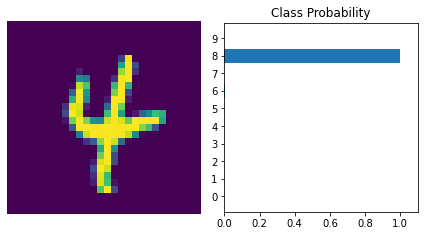

In [9]:
# Now let's start training the network
# Regular training, on clean data only
model = utils.train_model(model, X_train, X_test, y_train, y_test, epochs=5)

### Input Space (Dimensionality Reduction) Transforms - optional

In [10]:
# SKLearn method for determining a "minimum" number of components to reduce the dataset to
n_comp = johnson_lindenstrauss_min_dim(X_train.shape[0], eps=.99)

# Control (no transform): Wall time: 2min 53s, clean: 0.9733, adv: 0.8829
transformer = None

# GaussianRandomProjection(n_components=374): Wall time: 1min 47s, clean: 0.9737, adv: 0.8892
# 2nd run: Wall time: 1min 52s, clean: 0.9727, adv: 0.911
#transformer = random_projection.GaussianRandomProjection(n_components=n_comp)

# SparseRandomProjection(n_components=374): Wall time: 1min 46s, clean: 0.9744, adv: 0.9247
# 2nd run: Wall time: 1min 47s, clean: 0.9706, adv: 0.8998
#transformer = random_projection.SparseRandomProjection(n_components=n_comp)

# PCA(n_components=374): Wall time: 1min 53s, clean: 0.9783, adv: 0.9137
# 2nd run: Wall time: 1min 32s, clean: 0.9757, adv: 0.9028
#transformer = PCA(n_components=n_comp)

# FeatureAgglomeration(n_clusters=10):  Wall time: 46.2 s, clean: 0.8512, adv: 0.782
#transformer = cluster.FeatureAgglomeration(n_clusters=10)

# TSNE
# transformer = TSNE(n_components=n_comp, 
#                    #perplexity = 50, 
#                    #n_iter = 10000, 
#                    method="exact")
# TSNE doesn't come up with a single embedding and apply that embedding to different datasets, it operates directly on the data
# provided to produce the embedding. This means that using a different dataset for train/test time can produce vastly different 
# embeddings, which doesn't lend itself well to our use-case, which is fitting test-time embeddings into clusters made at 
# training time. 
# It is possible to append test data to train data so that the embedding at test time is similar to that of training time. 
# However, this doesn't scale well, and on my PC I was running into memory issues just trying to apply TSNE on the training 
# data alone (I have about 16 gigs of RAM, sklearn wanted to allocate 28.6 gigs for TSNE)
# Theoretically, I could try applying PCA to reduce dimensionality as a first step and then apply TSNE to get around this. That
# would still require including the (reduced dimensionality) training set for creating the embedding at test time though. 

# UMAP
# transformer = umap.UMAP(n_components = n_comp,
#                         min_dist = 0.05,
#                         n_neighbors = 15,
#                         metric = "euclidean")

### Fitting the clustering classifier on clean data

In [11]:
# Trying out different parameters for the clustering algorithm:
# Base: C=1, no transform
# Clean data flagged as suspicious by detector: 2.820%
# {'0.02': 97.28999999999999, '0.04': 96.53, '0.08': 93.91000000000001, '0.16': 83.16, '0.24': 64.78, '0.32': 48.89}
# {'0.02': 3.9600000000000004, '0.04': 5.83, '0.08': 14.02, '0.16': 47.75, '0.24': 55.300000000000004, '0.32': 58.68}

# C = 10, no transform
# Clean data flagged as suspicious by detector: 2.000%
# {'0.02': 97.97, '0.04': 97.18, '0.08': 94.72, '0.16': 81.39, '0.24': 68.08, '0.32': 53.21}
# {'0.02': 2.56, '0.04': 3.85, '0.08': 9.180000000000001, '0.16': 41.980000000000004, '0.24': 56.19, '0.32': 62.63999999999999}

# C = 15, no transform
# Clean data flagged as suspicious by detector: 1.930%
# {'0.02': 97.05, '0.04': 96.22, '0.08': 92.35, '0.16': 84.15, '0.24': 68.58999999999999, '0.32': 52.1}
# {'0.02': 2.58, '0.04': 3.5000000000000004, '0.08': 8.51, '0.16': 37.45, '0.24': 52.459999999999994, '0.32': 60.96}

# C = 20, no transform
# Clean data flagged as suspicious by detector: 1.800%
# {'0.02': 97.92999999999999, '0.04': 97.33000000000001, '0.08': 95.08, '0.16': 84.57000000000001, '0.24': 67.49000000000001, '0.32': 47.910000000000004}
# {'0.02': 2.32, '0.04': 3.2300000000000004, '0.08': 7.7, '0.16': 38.0, '0.24': 65.59, '0.32': 75.13}

########### Best so far
# C = 25, no transform
# Clean data flagged as suspicious by detector: 1.840%
# {'0.02': 97.76, '0.04': 97.25, '0.08': 95.19999999999999, '0.16': 87.52, '0.24': 73.04, '0.32': 54.510000000000005}
# {'0.02': 2.12, '0.04': 2.83, '0.08': 6.21, '0.16': 26.14, '0.24': 40.82, '0.32': 48.18}

# C = 30, no transform
# Clean data flagged as suspicious by detector: 1.820%
# {'0.02': 97.72999999999999, '0.04': 96.91, '0.08': 93.61, '0.16': 82.12, '0.24': 65.11, '0.32': 43.919999999999995}
# {'0.02': 2.2800000000000002, '0.04': 3.2399999999999998, '0.08': 8.34, '0.16': 41.97, '0.24': 61.51, '0.32': 59.06}

# C = 50, no transform
# Clean data flagged as suspicious by detector: 1.880%
# {'0.02': 97.67, '0.04': 96.63000000000001, '0.08': 92.86, '0.16': 79.74, '0.24': 67.77, '0.32': 46.94}
# {'0.02': 2.41, '0.04': 3.44, '0.08': 7.17, '0.16': 33.39, '0.24': 63.93, '0.32': 75.21}

# C = 100, no transform
# Clean data flagged as suspicious by detector: 1.810%
# {'0.02': 97.46000000000001, '0.04': 96.50999999999999, '0.08': 92.94, '0.16': 81.55, '0.24': 62.06, '0.32': 45.24}
# {'0.02': 2.4899999999999998, '0.04': 3.75, '0.08': 10.02, '0.16': 39.739999999999995, '0.24': 60.550000000000004, '0.32': 62.27}

In [12]:
classifier = Classifier(model, input_transform = transformer, SVC_C = 25)

classifier.fit(X_train, y_train)

In [13]:
print(classifier.output_cluster.n_features_in_)

10


## Evaluation

### Scoring classifiers on clean data

In [14]:
print("Baseline classifier on clean test data: %.3f%%" % (utils.eval_model(baseline_model, X_test, y_test) * 100))

print("\nCluster Classifier Accuracy on clean test data: %.3f%%" % (classifier.score(X_test, y_test) * 100))
print("Clean data flagged as suspicious by detector: %.3f%%" % (classifier.proportion_flagged * 100))

Baseline classifier on clean test data: 99.190%

Cluster Classifier Accuracy on clean test data: 97.950%
Clean data flagged as suspicious by detector: 1.800%


## Evaluating on adversarial data

Baseline training epsilon: 0.02

Current epsilon: 0.02


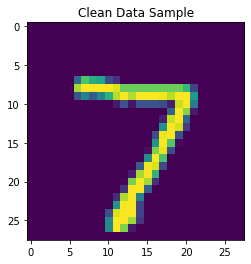

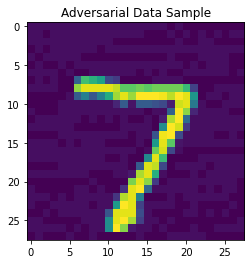

	Adversarial data only:
		Baseline classifier accuracy: 99.290%

		Cluster classifier accuracy: 97.510%
		Input data flagged as suspicious by detector: 2.270%

Current epsilon: 0.04


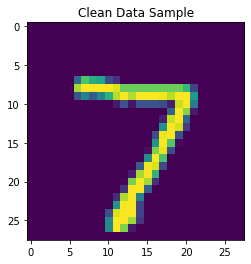

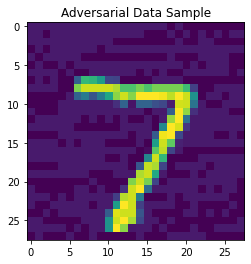

	Adversarial data only:
		Baseline classifier accuracy: 99.280%

		Cluster classifier accuracy: 96.330%
		Input data flagged as suspicious by detector: 3.180%

Current epsilon: 0.08


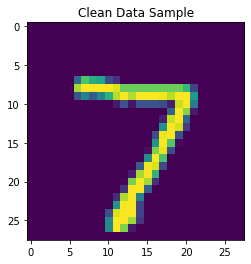

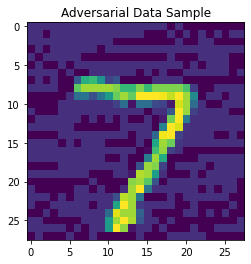

	Adversarial data only:
		Baseline classifier accuracy: 98.920%

		Cluster classifier accuracy: 91.600%
		Input data flagged as suspicious by detector: 9.610%

Current epsilon: 0.16


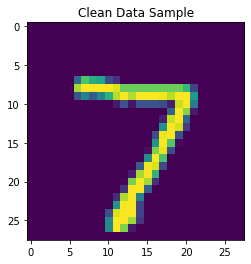

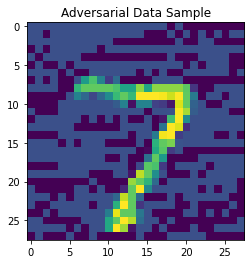

	Adversarial data only:
		Baseline classifier accuracy: 88.730%

		Cluster classifier accuracy: 82.050%
		Input data flagged as suspicious by detector: 53.440%

Current epsilon: 0.24


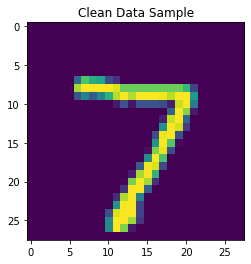

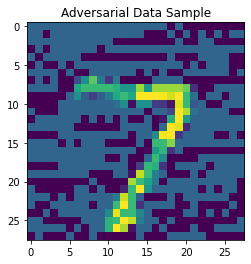

	Adversarial data only:
		Baseline classifier accuracy: 59.350%

		Cluster classifier accuracy: 67.250%
		Input data flagged as suspicious by detector: 69.640%

Current epsilon: 0.32


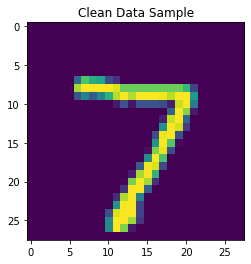

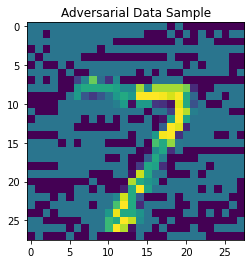

	Adversarial data only:
		Baseline classifier accuracy: 37.260%

		Cluster classifier accuracy: 48.800%
		Input data flagged as suspicious by detector: 75.180%


In [15]:
test_eps = [2e-2, 4e-2, 8e-2, 1.6e-1, 2.4e-1, 3.2e-1]
print("Baseline training epsilon: %.2f" % (baseline_training_eps))

baseline_performance = dict()
clustering_classifier_performance = dict()
clustering_detector_performance = dict()

for eps in test_eps:
    adv_test_data = utils.add_adversarial_noise(attacked_model, test_dataloader, eps=eps)
    
    print("\nCurrent epsilon: %.2f" % (eps))
    
    plt.imshow(X_test[0].reshape(dimensions))
    plt.title("Clean Data Sample")
    plt.show()

    plt.imshow(adv_test_data[0].reshape(dimensions))
    plt.title("Adversarial Data Sample")
    plt.show()
    
    # Testing both classifiers on adversarial data only
    # Baseline accuracy
    baseline_performance[str(eps)] = utils.eval_model(baseline_model, adv_test_data, y_test) * 100
    
    print("\tAdversarial data only:")
    print("\t\tBaseline classifier accuracy: %.3f%%" % (baseline_performance[str(eps)]))

    # Clustering classifier and adversarial detection accuracy
    clustering_classifier_performance[str(eps)] = classifier.score(adv_test_data, y_test) * 100
    clustering_detector_performance[str(eps)] = classifier.proportion_flagged * 100
    
    print("\n\t\tCluster classifier accuracy: %.3f%%" % (clustering_classifier_performance[str(eps)]))
    print("\t\tInput data flagged as suspicious by detector: %.3f%%" % (clustering_detector_performance[str(eps)]))
    
    # Testing both classifiers on both clean and adversarial data 1:1 ratio
#     test_data = np.concatenate((X_test, adv_test_data), axis=0)

#     print("\n\tClean and adversarial data:")
#     print("\t\tBaseline classifier accuracy: %.3f%%" % (utils.eval_model(baseline_model, test_data, test_labels) * 100))

#     print("\n\t\tCluster classifier accuracy: %.3f%%" % (classifier.score(test_data, test_labels) * 100))
#     print("\t\tInput data flagged as suspicious by detector: %.3f%%" % (classifier.proportion_flagged * 100))

In [16]:
print(clustering_classifier_performance)
print(clustering_detector_performance)

{'0.02': 97.50999999999999, '0.04': 96.33, '0.08': 91.60000000000001, '0.16': 82.05, '0.24': 67.25, '0.32': 48.8}
{'0.02': 2.27, '0.04': 3.18, '0.08': 9.610000000000001, '0.16': 53.44, '0.24': 69.64, '0.32': 75.18}
